## Introduction

The Crossref REST API is entirely based on URLs and is [documented extensively](https://api.crossref.org). This means, that, in theory, you can simply get all the data that you want using a normal browser. For example, you might want to see the latest DOI records in the Crossref system. You can see this with the following URL:

[`https://www.crossref.org/works`](https://api.crossref.org/works)


This means the REST API is pretty easy to use with basic low level HTTP libraries(e.g. Python's `requests`), but for this tutorial we are going to use a [higher level python library](https://github.com/fabiobatalha/crossrefapi) developed by Fabio Batalha C. Santos at [SciELO](http://www.scielo.org).

The examples here are in Python 3. Sorry- but you're going to have to make the move sometime ;)

To use this libra ry you can:

`pip install crossrefapi`

Then, import the library and get ready to look at so `works` data. 

## Working with "works"

Let's start by looking briefly at"works". The route refers to items identified by a DOI in the index. These can be articles, books, components, etc.

**TIP:** Crossref does not use "works" in the [FRBR](https://en.wikipedia.org/wiki/Functional_Requirements_for_Bibliographic_Records) sense of the word. In Crossref parlance, a "work" is just a thing identified by a DOI. In practice, Crossref DOIs are used as citation identifiers. So, in FRBR terms, this means, that a Crossref DOI tends to refer to one _expression_ which might include multiple _manifestations_. So, for example, the ePub, HTML and PDF version of an article will share a Crossref DOI because the differences between them should not effect the interpretation or crediting of the content. In short, they can be cited interchangeably. The same is true of the "accepted manuscript" and the "version-of-record" of that accepted manuscript.

In order to start querying information about works, we need to import the library and make things convenient.

In [2]:
from crossref.restful import Works
works = Works()

Now we are ready to ask our first question- How many Crossref DOI records are indexed by the API?

In [3]:
works.count()

167878179

Note that above I said "How many Crossref DOIs". There are several other [DOI registration agencies](https://www.doi.org/registration_agencies.html). Crossref is by far he largest DOI RA, and the other RAs tend to specialize in orthoganal areas (e.g. Music & Video, Local language translations of publications, etc.) but it is important to not that this API will not work with non-Crossref DOIs (though [DataCite](https://www.datacite.org/), another RA, provides a very similar API).

**TIP:** Not all DOIs are Crossref DOIs. If you are having trouble using a DOI with Crossref's API, check to see if it is a Crossref DOI.

So the next obvious question is, how do I tell if a DOI is a Crossref DOI?

In [12]:
works.agency('10.1590/0102-311x00133115')

{'DOI': '10.1590/0102-311x00133115',
 'agency': {'id': 'crossref', 'label': 'Crossref'}}

In [13]:
works.agency('10.6084/m9.figshare.1314859.v1')

{'DOI': '10.6084/m9.figshare.1314859.v1',
 'agency': {'id': 'datacite', 'label': 'DataCite'}}

In [14]:
works.agency('10.5240/B1FA-0EEC-C316-3316-3A73-L')

{'DOI': '10.5240/b1fa-0eec-c316-3316-3a73-l',
 'agency': {'id': 'eidr', 'label': 'EIDR'}}

OK, so assuming that we are using a Crossref DOI, how do we get the metadata for it?

In [15]:
record = works.doi('10.7554/eLife.09561')
record

{'indexed': {'date-parts': [[2025, 2, 21]],
  'date-time': '2025-02-21T20:13:53Z',
  'timestamp': 1740168833243,
  'version': '3.37.3'},
 'reference-count': 71,
 'publisher': 'eLife Sciences Publications, Ltd',
 'license': [{'start': {'date-parts': [[2015, 9, 10]],
    'date-time': '2015-09-10T00:00:00Z',
    'timestamp': 1441843200000},
   'content-version': 'vor',
   'delay-in-days': 0,
   'URL': 'http://creativecommons.org/licenses/by/4.0/'},
  {'start': {'date-parts': [[2015, 9, 10]],
    'date-time': '2015-09-10T00:00:00Z',
    'timestamp': 1441843200000},
   'content-version': 'am',
   'delay-in-days': 0,
   'URL': 'http://creativecommons.org/licenses/by/4.0/'},
  {'start': {'date-parts': [[2015, 9, 10]],
    'date-time': '2015-09-10T00:00:00Z',
    'timestamp': 1441843200000},
   'content-version': 'tdm',
   'delay-in-days': 0,
   'URL': 'http://creativecommons.org/licenses/by/4.0/'}],
 'funder': [{'DOI': '10.13039/100006363',
   'name': 'National Geographic Society',
   'doi-as

This is basically a huge JSON object, so you can retrieve individual elements from it. Here is the publisher:

In [16]:
record['publisher']

'eLife Sciences Publications, Ltd'

And here is the license for the "version of record":

In [24]:
next((item for item in record['license'] if item["content-version"] == "vor"))['URL']

'http://creativecommons.org/licenses/by/4.0/'

Um... That was complicated. What does 'vor' mean?

**TIP:** Publishers sometimes record information for multiple versions of the content identified by a DOI. These versions should be interchaneable from the point of view of citation, but sometimes one version has more "features" than another. For example, it might be typset or have references linked, etc. The two versions might also have different licenses and different URLs. The terminology publishers use for identifying versions comes from the [NISO standard call JAV (Journal Article Version)](http://www.niso.org/publications/rp/RP-8-2008.pdf) and, although this terminology is [sometimes problematic](https://f1000research.com/articles/6-608/v1), you should be aware of it. In particualr, you will see two terms used  in Crossref metadata:

- `VOR` = Version of Record
- `AM` = Accepted Manuscript



Now that we know what 'vor' means, let's get the link to the full text of the version of record:

In [21]:
next((item for item in record['link'] if item["content-version"] == "vor"))['URL']

'http://elifesciences.org/lookup/doi/10.7554/eLife.09561'

The above has given us a brief overview of how to get a record and elements of a record identified with a Crossref DOI. Obviously, the goal is to do this in bulk. That is, to select and process records for multiple Crossref DOIs. Before we do that, it is helpful to familiarise yourself with some of the other "routes" supported by the REST API. This is because more advanced usage of the API typically involveds combining information from several routes. 

## Members

Crossref is a membership organization. DOI records are registered and managed by those members. It is often very useful to break down Crossref DOI records by member. But first let's find out a little bit more about members.

First we import and setup a useful shortcut. 

In [28]:
from crossref.restful import Members
members = Members()

How many members does Crossref have?

In [29]:
members.count()

29014

Let's look at a partciular member, Hindawi:

In [ ]:
pub = next(iter(members.query('Hindawi')))
pub

**TIP:** Many people make the mistake of thinking that a "DOI prefix" can be used to identify the member responsible for a Crossref DOI. This is not true. DOI prefixes merely serve as a namespace form which a member can create new DOIs without worrying about collisions. But, once created, Crossref DOIs are often transferred between publishers and so a Crossref member will often be responsible for DOIs with a variety of prefixes. So, for example, above, Hindawi is responsible for several prefixes:

In [31]:
prefixes = [p['value'] for p in pub['prefix']]
prefixes

['10.7167',
 '10.1100',
 '10.1155',
 '10.5402',
 '10.7217',
 '10.4061',
 '10.6064',
 '10.3814']

**TIP** The most accurate way to refer a particular Crossref member and *all* their prefixes is through the member's `id`.

So let's look at eLife.

In [32]:
pub = next(iter(members.query('eLife')))
pub

{'last-status-check-time': 1743033759194,
 'primary-name': 'eLife Sciences Publications, Ltd',
 'counts': {'current-dois': 45036,
  'backfile-dois': 43092,
  'total-dois': 88128},
 'breakdowns': {'dois-by-issued-year': [[2024, 25814],
   [2023, 12876],
   [2022, 7502],
   [2021, 7284],
   [2025, 6346],
   [2020, 6191],
   [2019, 4861],
   [2017, 4118],
   [2018, 4058],
   [2016, 3514],
   [2015, 2808],
   [2014, 1786],
   [2013, 811],
   [2012, 159]]},
 'prefixes': ['10.7554'],
 'coverage': {'affiliations-current': 0.4864996891375788,
  'similarity-checking-current': 0.2781108446576072,
  'descriptions-current': 0.0,
  'ror-ids-current': 0.2689626076916245,
  'funders-backfile': 0.2894040657198552,
  'licenses-backfile': 0.999976793836443,
  'funders-current': 0.1110889066524558,
  'affiliations-backfile': 0.9909728023763111,
  'resource-links-backfile': 0.3254664438874965,
  'orcids-backfile': 0.89578111946533,
  'update-policies-current': 0.1195488054001243,
  'ror-ids-backfile': 0.2

eLife's Crossref member ID can be accessed as follows:

In [33]:
pub_id = pub['id']
pub_id

4374

Now we can use this ID to specifically refer to eLife. For example:

In [34]:
pub = members.member(pub_id)
pub

{'last-status-check-time': 1743033759194,
 'primary-name': 'eLife Sciences Publications, Ltd',
 'counts': {'current-dois': 45036,
  'backfile-dois': 43092,
  'total-dois': 88128},
 'breakdowns': {'dois-by-issued-year': [[2024, 25814],
   [2023, 12876],
   [2022, 7502],
   [2021, 7284],
   [2025, 6346],
   [2020, 6191],
   [2019, 4861],
   [2017, 4118],
   [2018, 4058],
   [2016, 3514],
   [2015, 2808],
   [2014, 1786],
   [2013, 811],
   [2012, 159]]},
 'prefixes': ['10.7554'],
 'coverage': {'affiliations-current': 0.4864996891375788,
  'similarity-checking-current': 0.2781108446576072,
  'descriptions-current': 0.0,
  'ror-ids-current': 0.2689626076916245,
  'funders-backfile': 0.2894040657198552,
  'licenses-backfile': 0.999976793836443,
  'funders-current': 0.1110889066524558,
  'affiliations-backfile': 0.9909728023763111,
  'resource-links-backfile': 0.3254664438874965,
  'orcids-backfile': 0.89578111946533,
  'update-policies-current': 0.1195488054001243,
  'ror-ids-backfile': 0.2

Let's see how many DOIs eLife has registered by year:

In [35]:
dois_by_year = pub['breakdowns']['dois-by-issued-year']
dois_by_year

[[2024, 25814],
 [2023, 12876],
 [2022, 7502],
 [2021, 7284],
 [2025, 6346],
 [2020, 6191],
 [2019, 4861],
 [2017, 4118],
 [2018, 4058],
 [2016, 3514],
 [2015, 2808],
 [2014, 1786],
 [2013, 811],
 [2012, 159]]

Cool, now let's look at some of the publisher data in more friendly formats. We are going to use the pandas library for summarising and visualising the data.

In [36]:
import pandas as pd
%matplotlib ipympl

First let's see the publications by year in a nice, sorted table:

In [38]:
f = pd.DataFrame(dois_by_year)
f.columns = ['year','dois']
dois_sorted_by_year = f.sort_values(by='year')
dois_sorted_by_year

,year,dois
13,2012,159
12,2013,811
11,2014,1786
10,2015,2808
9,2016,3514
7,2017,4118
8,2018,4058
6,2019,4861
5,2020,6191
3,2021,7284


Maybe look at this in a graph?

In [ ]:
dois_sorted_by_year.plot.bar(x='year',y='dois')

We can pull this all together and you can look at a number of publishers. Try changing the publisher name in the code below to something else:

In [ ]:
publisher_name = 'Elsevier'
pub_id = next(iter(members.query(publisher_name)))['id']
pub = members.member(pub_id)
dois_by_year = pub['breakdowns']['dois-by-issued-year']
f = pd.DataFrame(dois_by_year)
f.columns = ['year','dois']
dois_sorted_by_year = f.sort_values(['year','dois'])
dois_sorted_by_year.plot.bar(x='year',y='dois')

A publisher record also contains a useful summary of the member's metadata and the Crossref services that they participate in.

Let's look at what percentage of their metadata includes certain information:

In [43]:
coverage = [[key,float(pub['coverage'][key])*100] for key in pub['coverage'].keys()]
coverage

[['affiliations-current', 0.009224069790843305],
 ['similarity-checking-current', 0.5960644941126372],
 ['descriptions-current', 0.0],
 ['ror-ids-current', 0.0],
 ['funders-backfile', 13.68873542038214],
 ['licenses-backfile', 92.41879620555554],
 ['funders-current', 30.48358188494778],
 ['affiliations-backfile', 0.01550191862453363],
 ['resource-links-backfile', 93.0681554360167],
 ['orcids-backfile', 6.644963980592319],
 ['update-policies-current', 80.22527147203029],
 ['ror-ids-backfile', 0.0],
 ['orcids-current', 36.37415306268284],
 ['similarity-checking-backfile', 2.67306911997817],
 ['references-backfile', 69.48777203880073],
 ['descriptions-backfile', 0.0],
 ['award-numbers-backfile', 9.067383802294412],
 ['update-policies-backfile', 28.88578948043411],
 ['licenses-current', 84.4395411444555],
 ['award-numbers-current', 19.20673728974225],
 ['abstracts-backfile', 0.018778826241924822],
 ['resource-links-current', 84.57360005600067],
 ['abstracts-current', 0.014437674455232998],

<Axes: ylabel='metadata'>

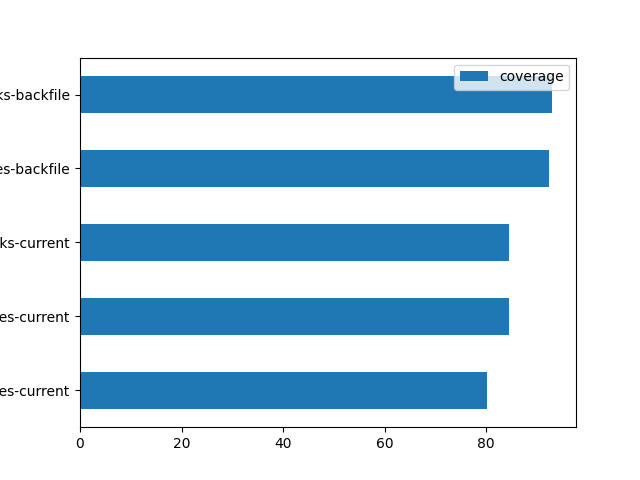

In [48]:
f = pd.DataFrame(coverage)
f.columns = ['metadata','coverage']
f.sort_values(by='coverage')[-5:].plot.barh(x='metadata',y='coverage')

Now let's see what Crossref services they participate in:

In [49]:
participation = [[key,pub['flags'][key]] for key in pub['flags'].keys()]
f = pd.DataFrame(participation)
f.columns = ['service','paticipation']
f

,service,paticipation
0,deposits-abstracts-current,True
1,deposits-orcids-current,True
2,deposits,True
3,deposits-affiliations-backfile,True
4,deposits-update-policies-backfile,True
5,deposits-similarity-checking-backfile,True
6,deposits-award-numbers-current,True
7,deposits-resource-links-current,True
8,deposits-ror-ids-current,False
9,deposits-articles,True


## Fun with facets

### ORCID support

In [54]:
from crossref.restful import Works
works = Works()
r = works.filter(has_orcid='true').facet('publisher-name',20)
orcid_support = [[key,r['publisher-name']['values'][key]] for key in r['publisher-name']['values'].keys()]
f = pd.DataFrame(orcid_support)
f.columns = ['publisher','orcids']
f['publisher']

0                                           Elsevier BV
1               Springer Science and Business Media LLC
2                                                 Wiley
3                                               MDPI AG
4                                    Informa UK Limited
5                       American Chemical Society (ACS)
6     Institute of Electrical and Electronics Engine...
7                                     SAGE Publications
8                      Royal Society of Chemistry (RSC)
9                         Oxford University Press (OUP)
10                        Cold Spring Harbor Laboratory
11                                      Copernicus GmbH
12                     Public Library of Science (PLoS)
13      American Association for Cancer Research (AACR)
14                         Research Square Platform LLC
15                                       IOP Publishing
16                                       AIP Publishing
17                                  FapUNIFESP (

## Zika publications

In [ ]:
r = works.query(title='Zika').facet('publisher-name',10)
zika_publications = [[key,r['publisher-name']['values'][key]] for key in r['publisher-name']['values'].keys()]
f = pd.DataFrame(zika_publications)
f.columns = ['publisher','publications']
f.plot.barh(x='publisher',y='publications')

## Some other resources

### Types

In [56]:
from crossref.restful import Types
types = [type['label'] for type in Types().all()]
types.sort()
types

['Book',
 'Book Chapter',
 'Book Section',
 'Book Series',
 'Book Set',
 'Book Track',
 'Component',
 'Database',
 'Dataset',
 'Dissertation',
 'Edited Book',
 'Grant',
 'Journal',
 'Journal Article',
 'Journal Issue',
 'Journal Volume',
 'Monograph',
 'Other',
 'Part',
 'Peer Review',
 'Posted Content',
 'Proceedings',
 'Proceedings Article',
 'Proceedings Series',
 'Reference Book',
 'Reference Entry',
 'Report',
 'Report Component',
 'Report Series',
 'Standard']

### Journals

In [57]:
from crossref.restful import Journals
journals = Journals()
journals.count()


145870

In [ ]:
journal = journals.journal('0028-0836')
journal

## A slight digression to discuss testing debugging queries

**TIP** One of the cool things about the library we are using, is that you can easily see the REST API URIs that it generates for queries you make to the API. To do this, you simply ask for the URL of the query in question. So, for example- if you want to see the API call for the code we used for asking for the number of Crossref DOIs.

In [59]:
from crossref.restful import Works
works = Works()
works.query('zika').url

'https://api.crossref.org/works?query=zika'

## Using samples for testing and to save time

In [ ]:
from crossref.restful import Works
works = Works()
zika_sample = [work for work in works.query('zika').sample(10)]
zika_sample

## Some Jisc Examples

### Notify institutions of co-authored works

Works records indexed _today_ that have affiliation data

In [61]:
import datetime
works=Works()
today = datetime.date.today().isoformat()
works_with_affiliations = [w for w in works.filter(from_online_pub_date=today, has_affiliation='true')]
print(len(works_with_affiliations))


1412


Let's look for publications with a publication date of today and a particular affiliation.

In [ ]:
import datetime
affiliation="Harvard"
today = datetime.date.today().isoformat()
recent_affiliation_pubs = works.filter(from_online_pub_date=today).query(affiliation=affiliation)
recent_affiliation_pubs.count()

Let's look at the first record...

In [ ]:
next(iter(recent_affiliation_pubs))

#### A digression on organizational identifiers...


### Integrate funding data into funder policy service

In [ ]:
from crossref.restful import Funders
funders=Funders()
funder_name="NIH"
funder_id=next(iter(funders.query(funder_name)))['id']
funder_id

In [ ]:
import datetime
works=Works()
today = datetime.date.today().isoformat()
works_with_funding_data = [w for w in works.filter(from_online_pub_date='2017-01-01', funder=funder_id)]
print(len(works_with_funding_data))

In [ ]:
next(iter(works_with_funding_data))

### 